In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
import sys
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

E:\Anaconda3\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Anaconda3\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def munge(data, train):
    data['HasName'] = data['Name'].fillna(0)
    data.loc[data['HasName'] != 0,"HasName"] = 1
    data['HasName'] = data['HasName'].astype(int)
    data['AnimalType'] = data['AnimalType'].map({'Cat':0,'Dog':1})

    if(train):
        data.drop(['AnimalID','OutcomeSubtype'],axis=1, inplace=True)
        data['OutcomeType'] = data['OutcomeType'].map({'Return_to_owner':4, 'Euthanasia':3, 'Adoption':0, 'Transfer':5, 'Died':2})
            
    gender = {'Neutered Male':1, 'Spayed Female':2, 'Intact Male':3, 'Intact Female':4, 'Unknown':5, np.nan:0}
    data['SexuponOutcome'] = data['SexuponOutcome'].map(gender)

    def agetodays(x):
        try:
            y = x.split()
        except:
            return None 
        if 'year' in y[1]:
            return float(y[0]) * 365
        elif 'month' in y[1]:
            return float(y[0]) * (365/12)
        elif 'week' in y[1]:
            return float(y[0]) * 7
        elif 'day' in y[1]:
            return float(y[0])
        
    data['AgeInDays'] = data['AgeuponOutcome'].map(agetodays)
    data.loc[(data['AgeInDays'].isnull()),'AgeInDays'] = data['AgeInDays'].median()

    data['Year'] = data['DateTime'].str[:4].astype(int)
    data['Month'] = data['DateTime'].str[5:7].astype(int)
    data['Day'] = data['DateTime'].str[8:10].astype(int)
    data['Hour'] = data['DateTime'].str[11:13].astype(int)
    data['Minute'] = data['DateTime'].str[14:16].astype(int)

    data['Name+Gender'] = data['HasName'] + data['SexuponOutcome']
    data['Type+Gender'] = data['AnimalType'] + data['SexuponOutcome']
    data['IsMix'] = data['Breed'].str.contains('mix',case=False).astype(int)
            
    return data.drop(['AgeuponOutcome','Name','Breed','Color','DateTime'],axis=1)

In [3]:
def best_params(data):
    rfc = RandomForestClassifier()
    param_grid = { 
        'n_estimators': [50, 400],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(data[0::,1::],data[0::,0])
    return CV_rfc.best_params_

In [4]:
in_file_train = 'data/train.csv'
in_file_test = 'data/test.csv'

print("Loading data...\n")
pd_train = pd.read_csv(in_file_train)
pd_test = pd.read_csv(in_file_test)
pd_train.head()

Loading data...



,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
pd_test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [6]:
print("Munging data...\n")
pd_train = munge(pd_train,True)
pd_test = munge(pd_test,False)

pd_test.drop('ID',inplace=True,axis=1)

train = pd_train.values
test = pd_test.values

print("Calculating best case params...\n")
# print(best_params(train))

Munging data...

Calculating best case params...



In [7]:
print(pd_train.shape)
print(pd_test.shape)
# print(pd_train.values[0])
# print(pd_test.values[0])

(26729, 13)
(11456, 12)


In [8]:
from sklearn.cross_validation import train_test_split
# 导入必要的工具包
# import xgboost as xgb
from xgboost import XGBClassifier
import xgboost as xgb
# 计算分类正确率
from sklearn.metrics import accuracy_score

train = pd_train.values
X, y = train[0::,1::], train[0::,0]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(16037, 12)
(16037,)
(5346, 12)
(5346,)
(5346, 12)
(5346,)


In [9]:
def getAccuracy(model, x_test, y_test):
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [10]:
# max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞]
# eta：为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 
# eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
# silent：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0
# objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示二分类的逻辑回归问题，输出为概率。

param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'multi:softmax' }
# bst = xgb.train(param, dtrain, num_round) #  dtrain是训练数据集

In [11]:
# 设置boosting迭代计算次数
num_round = 2
import time
starttime = time.clock()
model = xgb.sklearn.XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, n_jobs=-1)
eval_set = [(x_test, y_test)]
model.fit(X_train,y_train,eval_metric='auc')
endtime = time.clock()
print (endtime - starttime)

1.2997155126450588


In [12]:
# 设置boosting迭代计算次数
# 设置early_stopping_rounds=10，当logloss在10轮迭代之内，都没有提升的话，就stop。如果说eval_metric有很多个指标，那就以最后一个指标为准。
import time
starttime = time.clock()
model = xgb.sklearn.XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, n_jobs=-1)
# early_stopping_rounds=10
#设置验证集合 verbose=True打印过程
# eval_metric merror mlogloss
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (x_val, y_val)], eval_metric='mlogloss', early_stopping_rounds=10, verbose=False)
endtime = time.clock()
print (endtime - starttime)
getAccuracy(model, x_test, y_test)

1.7002687680491313
Accuracy: 66.35%


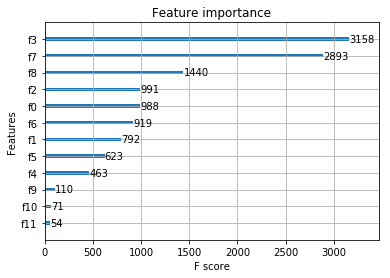

In [13]:
%matplotlib inline
from xgboost import plot_importance
from matplotlib import pyplot
model.fit(X_train, y_train)

plot_importance(model)
pyplot.show()

In [14]:
# GridSearchCV + XGBRegressor + early_stopping_rounds
# paramGrid = {"subsample" : [0.5, 0.8]}
# fit_params={"early_stopping_rounds":42, 
#             "eval_metric" : "mae", 
#             "eval_set" : [[testX, testY]]}
# model = xgb.XGBRegressor()
# gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
#          fit_params=fit_params,
#          cv=TimeSeriesSplit(n_splits=cv).get_n_splits([trainX,trainY]))
# gridsearch.fit(trainX,trainY)

In [15]:
from sklearn import cross_validation, metrics
from sklearn.model_selection import TimeSeriesSplit

def modelfit(alg, X_train=X_train, y_train=y_train, x_val=x_val, y_val=y_val,useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    #Fit the algorithm on the data
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X_train, label=y_train)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    eval_set = [(x_val, y_val)]
    starttime = time.clock()
    alg.fit(X_train,
            y_train,
            eval_set=[(X_train, y_train), (x_val, y_val)],
            eval_metric='mlogloss',
            early_stopping_rounds=10,
            verbose=False)
    endtime = time.clock()
    print('fit time:', endtime - starttime)
    #Predict training set:
    y_pred = model.predict(x_val)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_val, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    #Perform cross-validation:
    fit_params={'early_stopping_rounds': 30, 
            'eval_metric': 'merror', # importance
            'verbose': False,
            'eval_set': [[x_val, y_val]]} # importance
    cv = 2
    cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_train, y_train])
    cv_score = cross_validation.cross_val_score(alg,
                                                x_val,
                                                y_val,
                                                cv=cv,
                                                scoring='r2',
                                                fit_params = fit_params)
    cv_score = np.sqrt(np.abs(cv_score))
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_val, predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

In [16]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=17)

In [17]:
modelfit(alg=xgb1)

fit time: 1.946488275001876
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.1557 | Std - 0.0003811 | Min - 0.1553 | Max - 0.1561


In [21]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=27)
param_grid = {
    'max_depth':[5,7,9]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   32.0s finished


Best: 0.680364 using {'max_depth': 9}


In [22]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=9,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=37)
# modelfit(alg=xgb3)
param_grid = {
    'max_depth':[8, 9, 10]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   40.2s finished


Best: 0.680614 using {'max_depth': 8}


In [23]:
# gama Minimum loss reduction required to make a further partition on a leaf node of the tree.
xgb4 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=40)
modelfit(alg=xgb4)
param_grid = {
    'gamma':[i/10.0 for i in range(0,9,4)]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

fit time: 2.9198462972693733
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.06761 | Std - 0.01078 | Min - 0.05683 | Max - 0.07839
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   31.3s finished


Best: 0.681299 using {'gamma': 0.4}


In [24]:
# subsample Subsample ratio of the training instance.
# colsample_bytree Subsample ratio of columns when constructing each tree.
xgb5 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=8,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.75,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=50)
modelfit(alg=xgb5)
param_grid = {
     'subsample':[i/100.0 for i in range(75,86,5)],
     'colsample_bytree':[i/100.0 for i in range(75,86,5)]
}
starttime = time.clock()
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
endtime = time.clock()
print (endtime - starttime)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

fit time: 2.9693608273616405
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.1165 | Std - 0.02817 | Min - 0.08831 | Max - 0.1447
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   32.2s finished


Best: 0.680863 using {'subsample': 0.85, 'colsample_bytree': 0.85}
34.816588743822194
Best: 0.680863 using {'subsample': 0.85, 'colsample_bytree': 0.85}


In [25]:
# subsample Subsample ratio of the training instance.
# colsample_bytree Subsample ratio of columns when constructing each tree.
xgb6 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=8,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.85,
    colsample_bytree=0.85,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=60)
modelfit(alg=xgb6)
param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
starttime = time.clock()
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
endtime = time.clock()
print (endtime - starttime)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

fit time: 3.0540092891473023
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.0997 | Std - 0.04553 | Min - 0.05418 | Max - 0.1452
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   27.6s finished


30.152238268746203
Best: 0.679928 using {'reg_alpha': 1e-05}


In [26]:
# subsample Subsample ratio of the training instance.
# colsample_bytree Subsample ratio of columns when constructing each tree.
xgb6 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=11,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.85,
    colsample_bytree=0.85,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    seed=60)
modelfit(alg=xgb6)
param_grid = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
starttime = time.clock()
kfold = KFold(n_splits=5, shuffle=True, random_state=27)
# kfold = KFold(n_splits=5)
grid_search=RandomizedSearchCV(xgb2, param_grid, scoring='accuracy', cv=kfold, n_iter=3, verbose=1)
# grid_search = GridSearchCV(xgb2, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
endtime = time.clock()
print (endtime - starttime)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

fit time: 2.979767649411997
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.1317 | Std - 0.01306 | Min - 0.1186 | Max - 0.1447
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   32.3s finished


34.74239329959778
Best: 0.680364 using {'reg_alpha': 0.01}


In [27]:
# subsample Subsample ratio of the training instance.
# colsample_bytree Subsample ratio of columns when constructing each tree.
xgb7 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=100,
    max_depth=9,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.85,
    colsample_bytree=0.85,
    objective= 'multi:softmax',
    n_jobs=-1,
    scale_pos_weight=1,
    reg_alpha=0.01,
    seed=70)
modelfit(alg=xgb7)
# param_grid = {
#     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
# }
# starttime = time.clock()
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
# grid_search = GridSearchCV(xgb6, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
# grid_result = grid_search.fit(X_train, y_train)
# endtime = time.clock()
# print (endtime - starttime)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

fit time: 3.6036069069988343
Accuracy: 66.59%

Model Report
RMSE : 2.236
CV Score : Mean - 0.06669 | Std - 0.05135 | Min - 0.01534 | Max - 0.118


In [28]:
getAccuracy(xgb7, x_test, y_test)

Accuracy: 67.73%
